In [244]:
import pandas as pd
import numpy as np
import lightgbm
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [245]:
warnings.filterwarnings('ignore')

In [246]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [247]:
train_df_final.head()

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,...,temp_dp_interaction_evening_X_doy_sin_sq,temp_dp_interaction_evening_X_doy_cos_sq,temp_dp_interaction_morning_X_doy_cos_sq,STA_x_slp_X_doy_sin_sq,STA_x_slp_X_doy_cos_sq,clim_doy_sin_X_slp_avg_base,clim_doy_sin_slp_X_doy_cos,elev_X_slp_avg,dp_evening_avg_X_humidity_avg,elev_slp_avg_X_STA_slp_avg
0,0,-2.707143,-3.992857,115.62,0.017213,0.999852,9.426812,-16.808333,46.875000,-787.890625,...,0.029615,99.920107,127.438895,-0.881541,-2974.285840,-48.202603,-48.195461,119598.77325,-805.468750,-3.558264e+08
1,1,-3.646429,-1.653571,115.62,0.034422,0.999407,9.437325,-17.466667,45.500000,-794.733333,...,0.123110,103.780224,139.827463,-2.595330,-2187.838376,-129.926788,-129.849793,119683.07950,-775.016667,-2.621579e+08
2,2,-2.694643,-0.005357,115.62,0.051620,0.998667,9.448699,-17.645833,43.583333,-769.064236,...,0.269383,100.828117,124.610965,-7.249960,-2713.603741,-144.110419,-143.918294,119787.61925,-808.470833,-3.259246e+08
3,3,-2.501786,-0.898214,115.62,0.068802,0.997630,9.460926,-11.966667,53.166667,-636.227778,...,0.087480,18.392520,95.585368,-6.930954,-1457.218729,-177.599760,-177.178902,119294.78900,-297.733333,-1.746654e+08
4,4,-2.625000,-1.775000,115.62,0.085965,0.996298,9.473997,-15.729167,40.583333,-638.342014,...,0.865034,116.190521,82.468249,-5.823838,-782.251995,-231.959085,-231.100413,118848.68850,-814.372222,-9.366178e+07


# Dataset Splitting

In [248]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optuna Setup

In [249]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 512),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 52
    }
    model = lightgbm.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            lightgbm.early_stopping(stopping_rounds=100, verbose=False),
            lightgbm.log_evaluation(period=0)
        ]
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [250]:
# study = optuna.create_study(direction='minimize', study_name='lgbm_reg_opt')
# study.optimize(objective, n_trials=30, n_jobs=10)
# print("Best trial:")
# print(f"  RMSE: {study.best_value:.5f}")
# print(f"  Params: {study.best_params}")

# 4) Retrain final model with best params
# best_params = study.best_params.copy()
# best_params.update({
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'verbosity': -1,
#     'random_state': 52
# })

In [251]:
best_params = {'n_estimators': 6745, 'learning_rate': 0.06522862721033737, 'num_leaves': 388, 'max_depth': 5, 'subsample': 0.8466848255564012, 'colsample_bytree': 0.7841450269172936, 'min_child_weight': 1.742148924703299, 'reg_alpha': 7.56560286836146e-06, 'reg_lambda': 7.075276103206667, 'verbosity': -1}

# Fit

In [252]:
lgbm = lightgbm.LGBMRegressor(**best_params)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lightgbm.log_evaluation(period=0),
               lightgbm.early_stopping(stopping_rounds=100, verbose=False)],
)

y_pred = lgbm.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ LightGBM R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ LightGBM R²: 0.8090 | RMSE: 1.3087


# Feature Importance

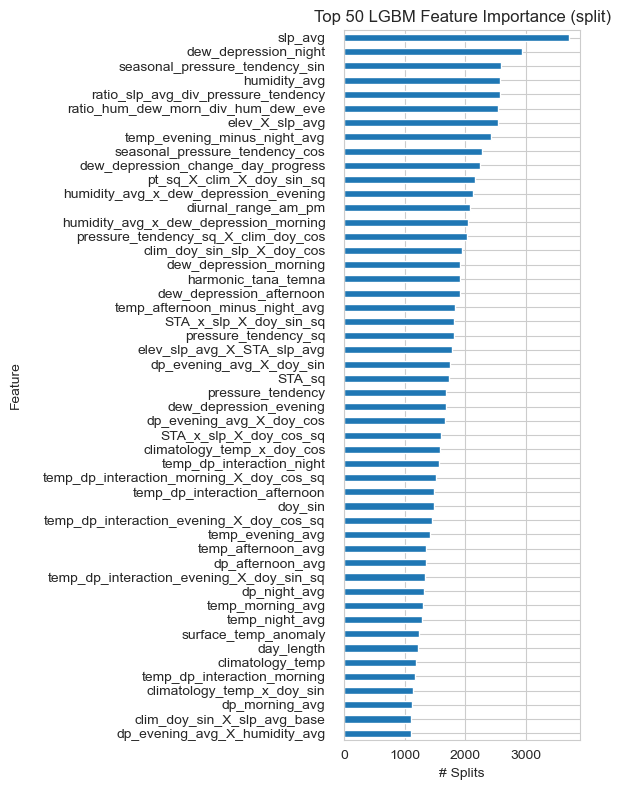

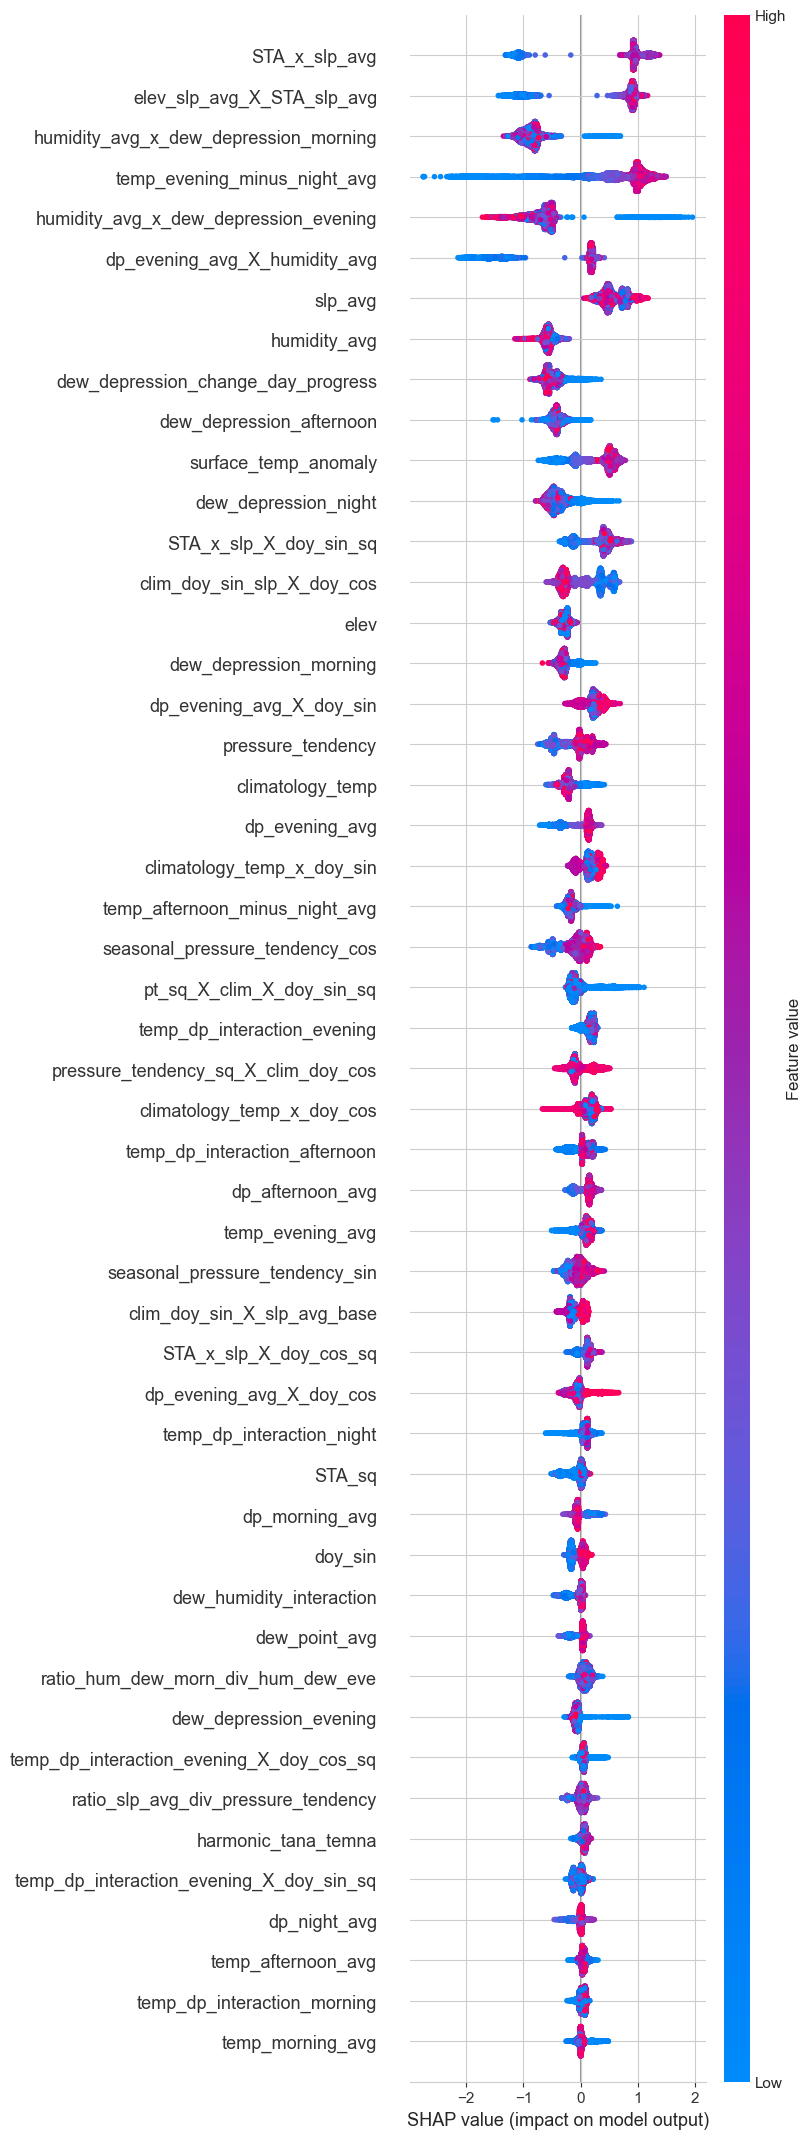

In [253]:
imp_split = lgbm.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 50

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N} LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [254]:
print(f"Top {top_N} LGBM Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 50 LGBM Importances (split):
slp_avg                                     3708
dew_depression_night                        2929
seasonal_pressure_tendency_sin              2586
humidity_avg                                2576
ratio_slp_avg_div_pressure_tendency         2571
ratio_hum_dew_morn_div_hum_dew_eve          2540
elev_X_slp_avg                              2536
temp_evening_minus_night_avg                2416
seasonal_pressure_tendency_cos              2280
dew_depression_change_day_progress          2244
pt_sq_X_clim_X_doy_sin_sq                   2156
humidity_avg_x_dew_depression_evening       2123
diurnal_range_am_pm                         2069
humidity_avg_x_dew_depression_morning       2041
pressure_tendency_sq_X_clim_doy_cos         2025
clim_doy_sin_slp_X_doy_cos                  1949
dew_depression_morning                      1913
harmonic_tana_temna                         1908
dew_depression_afternoon                    1905
temp_afternoon_minus_night_avg      

# Feature Selection with SHAP

In [255]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
surface_temp_anomaly                        0.409897
dew_depression_night                        0.387528
STA_x_slp_X_doy_sin_sq                      0.380931
clim_doy_sin_slp_X_doy_cos                  0.310537
elev                                        0.282213
dew_depression_morning                      0.281116
dp_evening_avg_X_doy_sin                    0.242021
pressure_tendency                           0.220251
climatology_temp                            0.217469
dp_evening_avg                              0.201684
climatology_temp_x_doy_sin                  0.182813
temp_afternoon_minus_night_avg              0.179099
seasonal_pressure_tendency_cos              0.166482
pt_sq_X_clim_X_doy_sin_sq                   0.156260
temp_dp_interaction_evening                 0.154448
pressure_tendency_sq_X_clim_doy_cos         0.151372
climatology_temp_x_doy_cos                  0.148768
temp_dp_interaction_afternoon               0.145765
dp_afternoon_avg     

In [256]:
print(feat_imp_split.to_string())

slp_avg                                     3708
dew_depression_night                        2929
seasonal_pressure_tendency_sin              2586
humidity_avg                                2576
ratio_slp_avg_div_pressure_tendency         2571
ratio_hum_dew_morn_div_hum_dew_eve          2540
elev_X_slp_avg                              2536
temp_evening_minus_night_avg                2416
seasonal_pressure_tendency_cos              2280
dew_depression_change_day_progress          2244
pt_sq_X_clim_X_doy_sin_sq                   2156
humidity_avg_x_dew_depression_evening       2123
diurnal_range_am_pm                         2069
humidity_avg_x_dew_depression_morning       2041
pressure_tendency_sq_X_clim_doy_cos         2025
clim_doy_sin_slp_X_doy_cos                  1949
dew_depression_morning                      1913
harmonic_tana_temna                         1908
dew_depression_afternoon                    1905
temp_afternoon_minus_night_avg              1836
STA_x_slp_X_doy_sin_

# Predict with Test Dataset

In [257]:
# y_test_pred = lgbm.predict(X_test_scaled)
#
# submission = pd.DataFrame({
#     "id": test_df_final["id"],
#     "target": y_test_pred
# })
#
# now = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# submission.to_csv(f'./output/submission_{now}.csv', index=False)